In [ ]:
!pip install pm4py ## runtime 수정이 반드시 필요함

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=f7685f6d0f488bfdaa732f31b3d1387ee362f1a1529f56cf7236c4ace2fc824e
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [66]:
import os
import pm4py
import graphviz
import pandas as pd
import datetime as dt
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer


In [16]:
sample = pd.read_csv('./sample.csv')

In [17]:
sample.head()

,proc_ym,proc_ymd,mcode,lecture_type,event,action,object_type,object_name,object_description,referrer_type,referrer_name,referrer_description,referrer_extensions_contentid,eventtime_kst,caliper_timestamp,data_source,yyyy,mm,dd
0,202108,20210809.0,NaN,NaN,SessionEvent,LoggedIn,SoftwareApplication,kr.hbstudy.apphbstudy,밀크T초등,NaN,NaN,NaN,NaN,2021-08-09 12:20:29.006,2021-08-09 12:20:29.006,e_session,2021.0,8.0,9.0
1,202108,20210809.0,NaN,NaN,SessionEvent,Paused,SoftwareApplication,kr.hbstudy.apphbstudy,밀크T초등,NaN,NaN,NaN,NaN,2021-08-09 12:26:05.250,2021-08-09 12:26:05.250,e_session,2021.0,8.0,9.0
2,202108,20210809.0,NaN,NaN,SessionEvent,Resumed,SoftwareApplication,kr.hbstudy.apphbstudy,밀크T초등,NaN,NaN,NaN,NaN,2021-08-09 12:51:45.020,2021-08-09 12:51:45.020,e_session,2021.0,8.0,9.0
3,202108,20210809.0,T0ME31U42019,T_TERMREVIEW,NavigationEvent,NavigatedTo,DigitalResource,준비하기,메뉴 인덱스 : 1,DigitalResource,인트로,메뉴 인덱스 : 0,T0ME31U42019,2021-08-09 12:53:45.834,2021-08-09 12:53:45.834,e_navigation,2021.0,8.0,9.0
4,202108,20210809.0,T0ME31U42019,T_TERMREVIEW,NavigationEvent,NavigatedTo,DigitalResource,개념 맛보기,메뉴 인덱스 : 2,DigitalResource,준비하기,메뉴 인덱스 : 1,T0ME31U42019,2021-08-09 12:54:00.839,2021-08-09 12:54:00.839,e_navigation,2021.0,8.0,9.0


In [19]:
case_list = []
case_number = 1

for ymd in sample['proc_ymd'].unique():
    target = sample[sample['proc_ymd'] == ymd]
    for case_add in range(len(target)):
        case_list.append(case_number)
    case_number += 1

sample['case_id'] = case_list

target = sample[['case_id','eventtime_kst','object_description']].dropna()
eventlog = target.rename(columns = {'case_id':'case:concept:name','eventtime_kst':'time:timestamp','object_description':'concept:name','userid':'org:resource'})

In [21]:
eventlog.head()

,case:concept:name,time:timestamp,concept:name
0,1,2021-08-09 12:20:29.006,밀크T초등
1,1,2021-08-09 12:26:05.250,밀크T초등
2,1,2021-08-09 12:51:45.020,밀크T초등
3,1,2021-08-09 12:53:45.834,메뉴 인덱스 : 1
4,1,2021-08-09 12:54:00.839,메뉴 인덱스 : 2


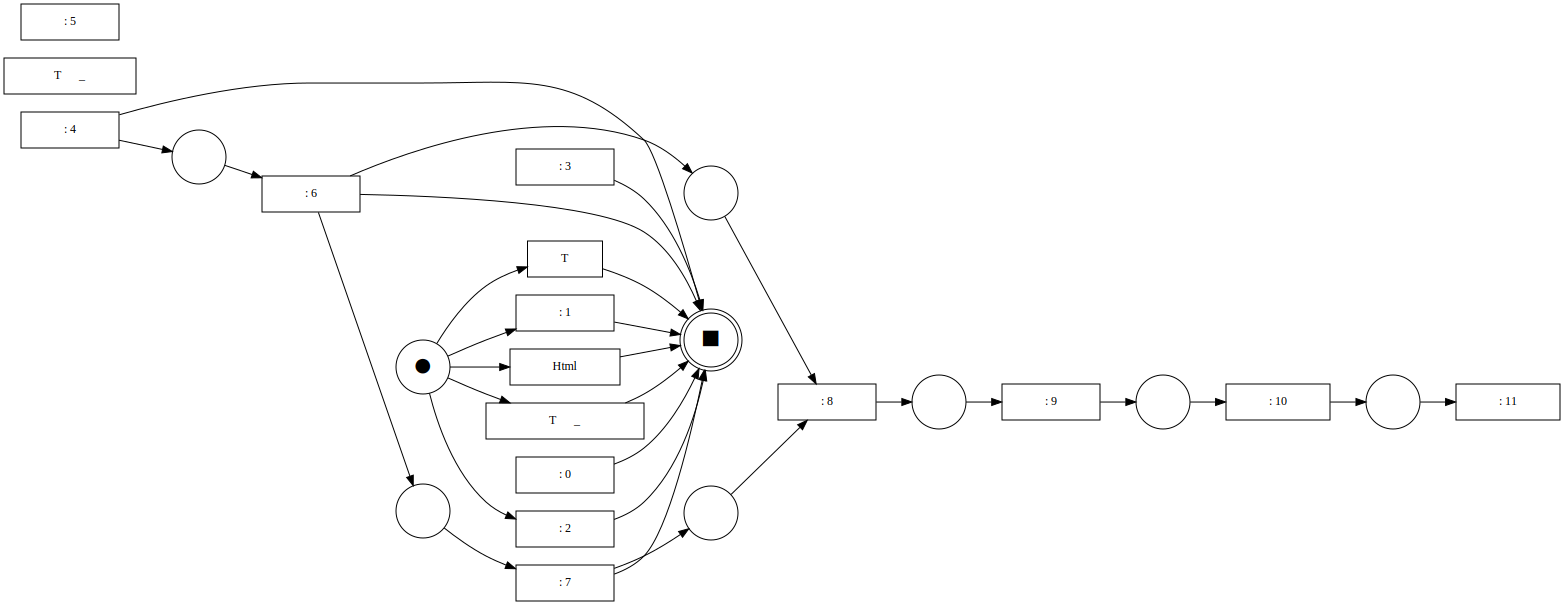

In [53]:
# Convert the log to a suitable format for alpha miner
log = log_converter.apply(eventlog)

# Discover the process model using alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Apply the Petri net visualizer
gviz = pn_visualizer.apply(net, initial_marking, final_marking)

# Convert the DOT source to a string
dot_string = gviz.source

# Render the modified DOT file using Graphviz
graph = graphviz.Source(dot_string)
graph

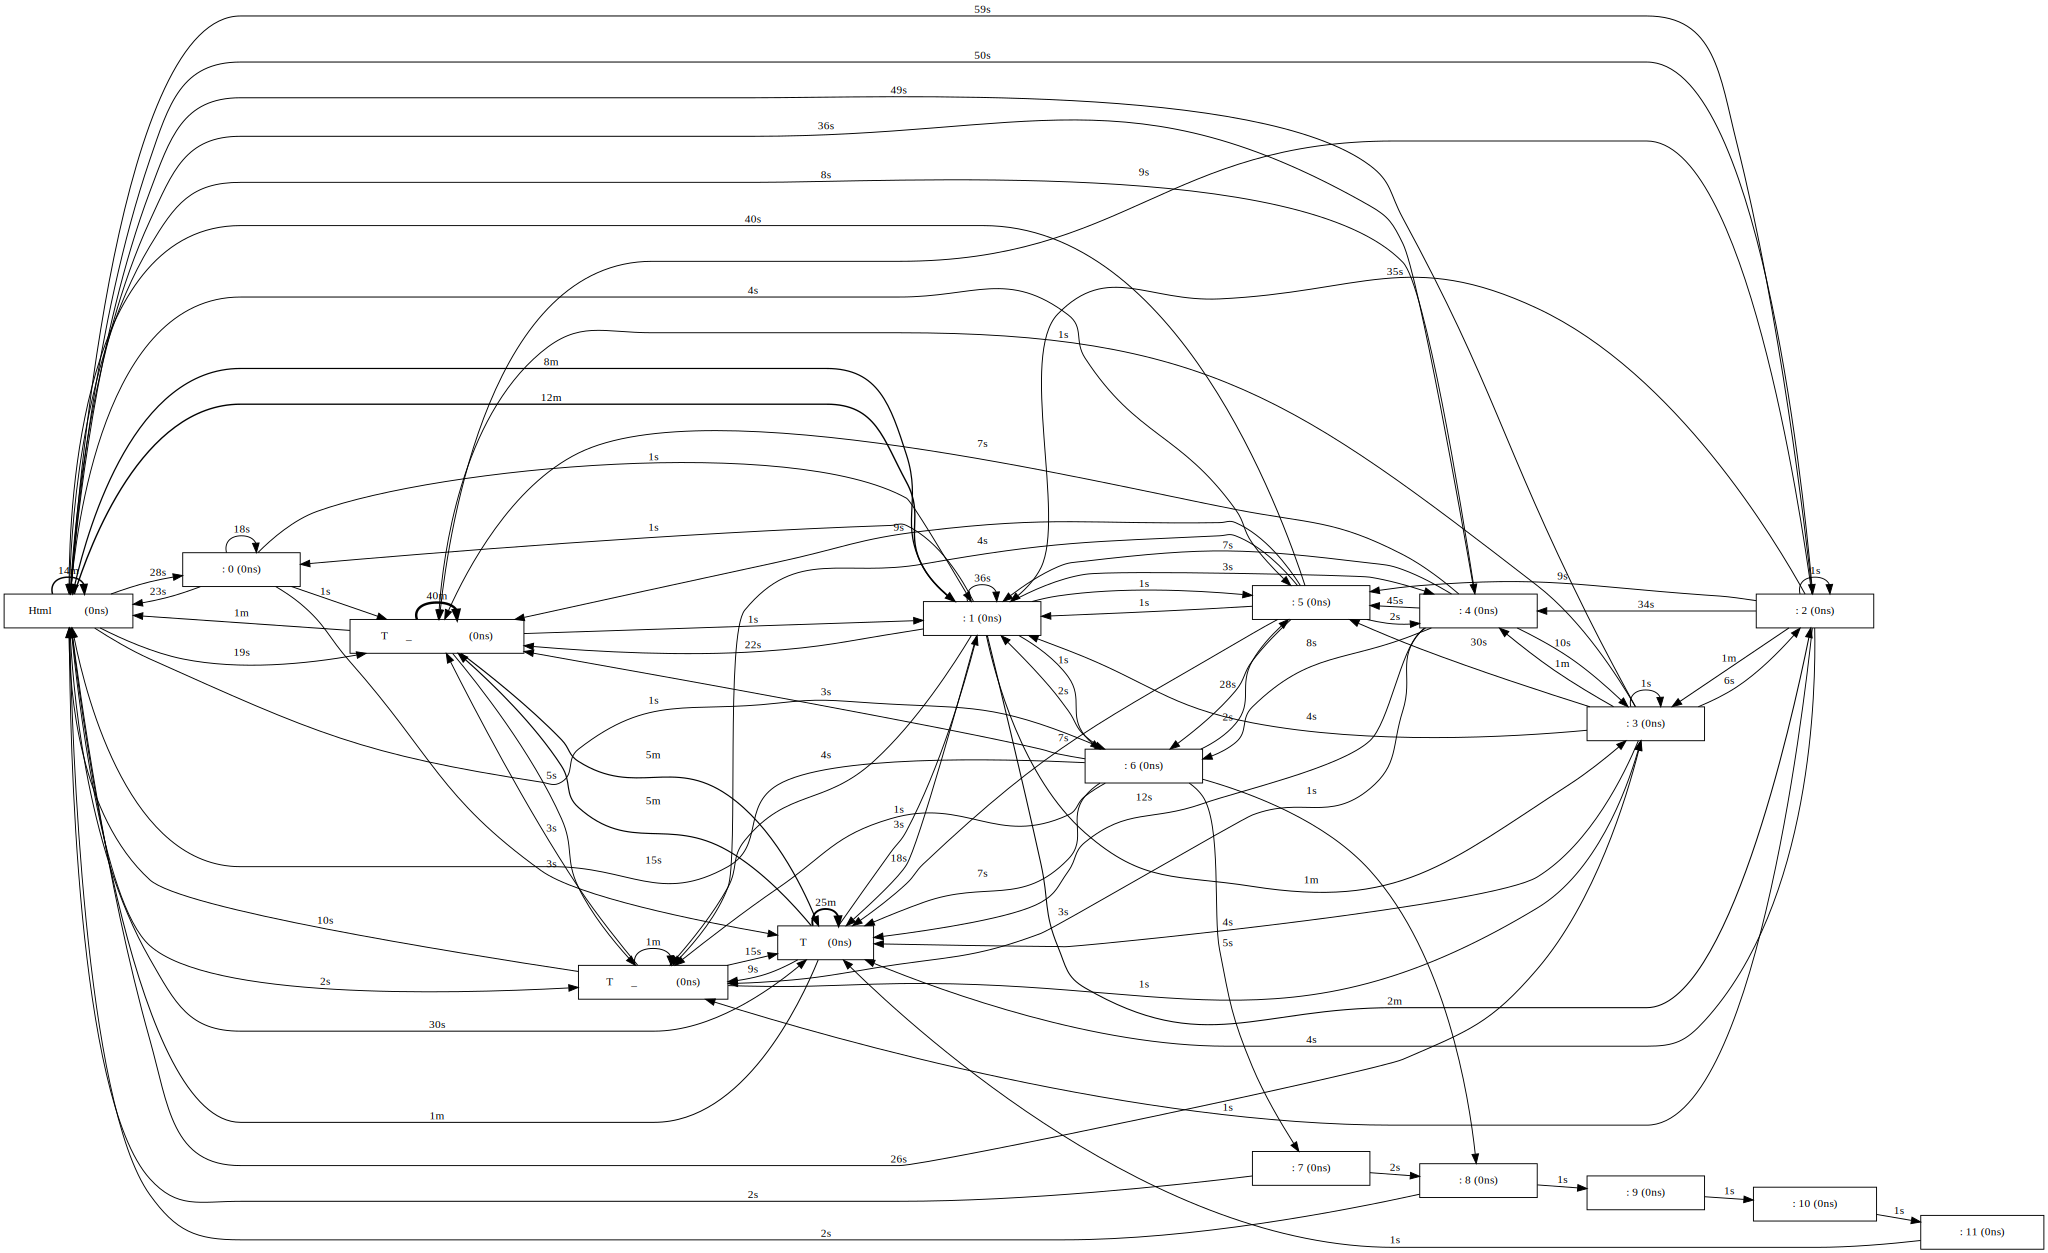

In [54]:
eventlog['time:timestamp'] = eventlog['time:timestamp'].apply(lambda x:pd.to_datetime(x))
log = log_converter.apply(eventlog)

dfg = dfg_discovery.apply(log)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)

dot_string = gviz.source

# Render the modified DOT file using Graphviz
graph = graphviz.Source(dot_string)
graph

[{'attributes': {'concept:name': 1}, 'events': [{'time:timestamp': Timestamp('2021-08-09 12:20:29.006000'), 'concept:name': '밀크T초등'}, '..', {'time:timestamp': Timestamp('2021-08-09 13:29:57.229000'), 'concept:name': '밀크T초등'}]}, '....', {'attributes': {'concept:name': 191}, 'events': [{'time:timestamp': Timestamp('2022-04-21 16:15:42.942000'), 'concept:name': '밀크T초등'}]}]

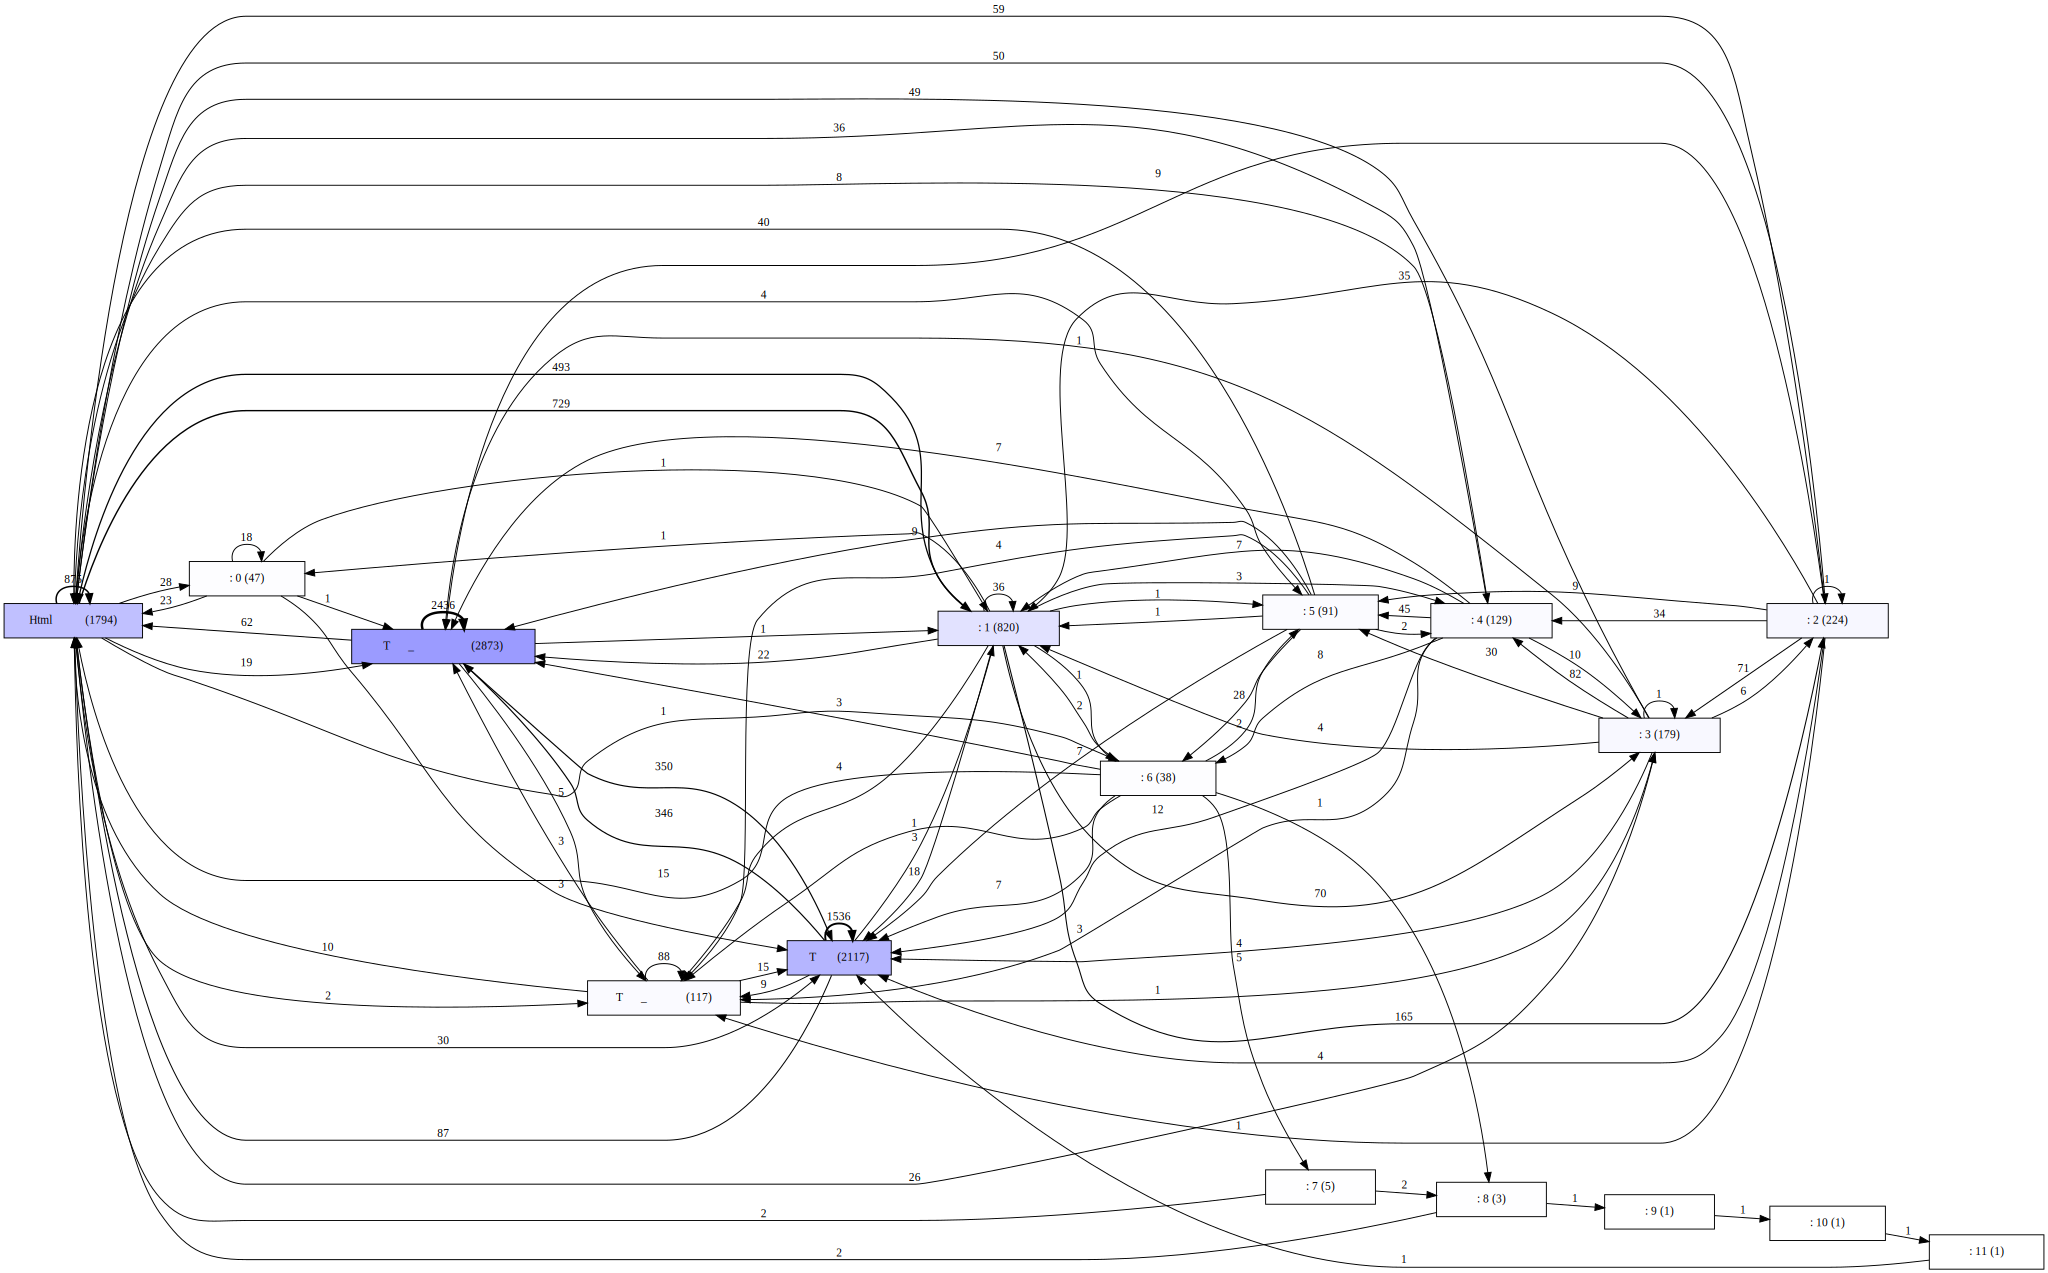

In [25]:
eventlog['time:timestamp'] = eventlog['time:timestamp'].apply(lambda x:pd.to_datetime(x))
filtered = pm4py.filter_time_range(eventlog, dt.datetime(2010, 12, 30), dt.datetime(2010, 12, 31), mode='events')


log = log_converter.apply(eventlog)

dfg = dfg_discovery.apply(log)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)

dot_string = gviz.source

# Render the modified DOT file using Graphviz
graph = graphviz.Source(dot_string)
graph

In [60]:
log_1 = log_converter.apply(log)
filtered = pm4py.get_event_attribute_values(log_1, "concept:name",{'밀크T초등'})

{'밀크T초등': 179,
 '메뉴 인덱스 : 1': 123,
 '메뉴 인덱스 : 6': 24,
 '메뉴 인덱스 : 5': 52,
 '메뉴 인덱스 : 2': 92,
 '메뉴 인덱스 : 4': 67,
 '메뉴 인덱스 : 0': 16,
 '노드 Html 학습창': 129,
 '밀크T초등_영상플레이어': 138,
 '메뉴 인덱스 : 3': 82,
 '밀크T초등_문제은행': 24,
 '메뉴 인덱스 : 8': 3,
 '메뉴 인덱스 : 10': 1,
 '메뉴 인덱스 : 9': 1,
 '메뉴 인덱스 : 11': 1,
 '메뉴 인덱스 : 7': 3}

In [ ]:
# # Save the modified DOT source to a new file
with open('modified_process_model.dot', 'w', encoding='utf-8') as file:
    file.write(dot_string)

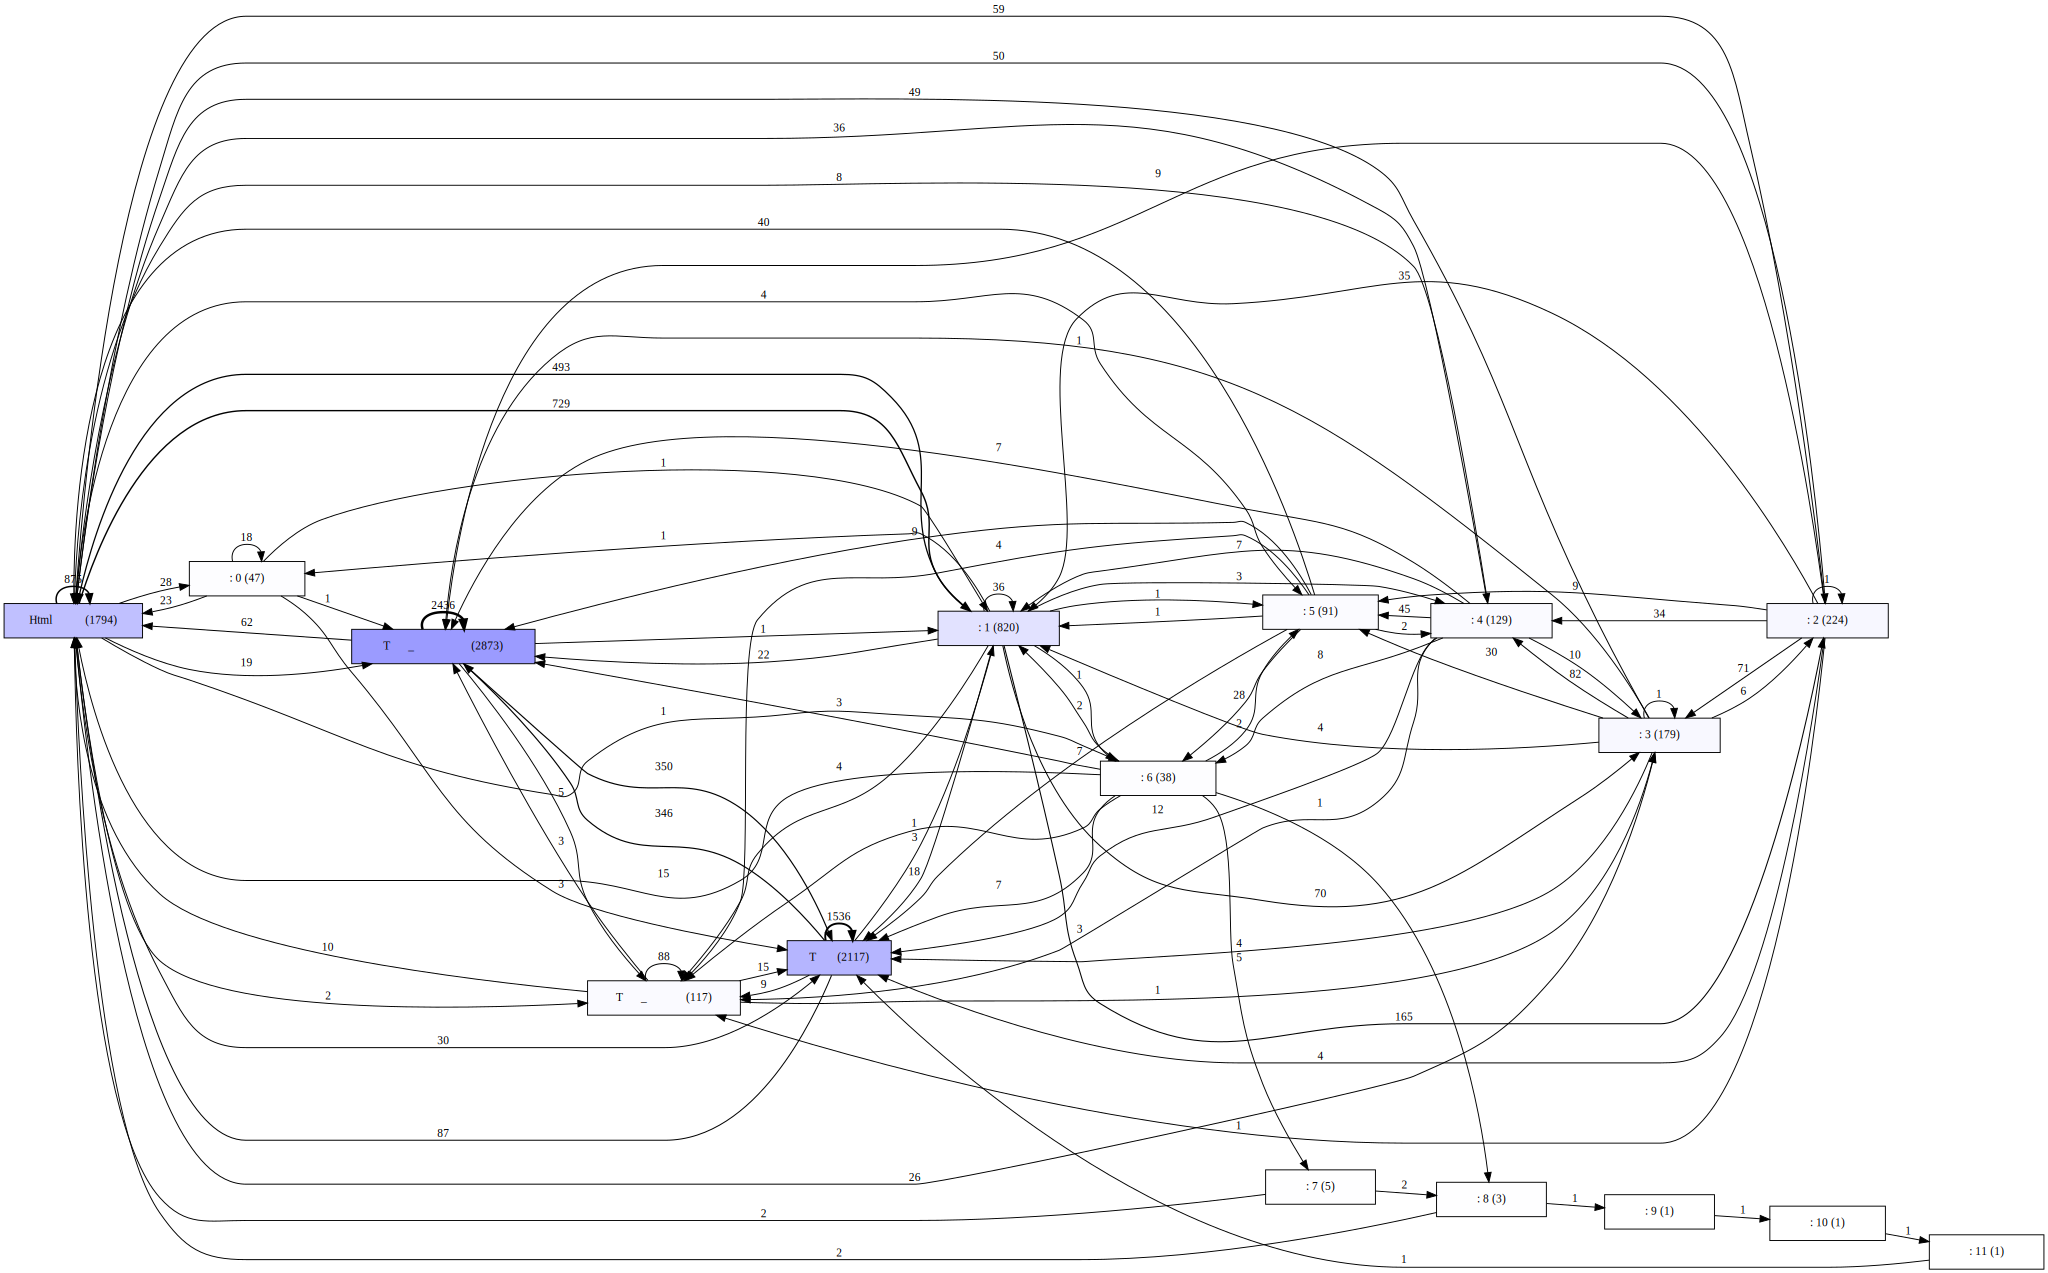

In [72]:
eventlog['time:timestamp'] = eventlog['time:timestamp'].apply(lambda x:pd.to_datetime(x))

log = log_converter.apply(eventlog)

dfg = dfg_discovery.apply(log)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)

dot_string = gviz.source

# Render the modified DOT file using Graphviz
graph = graphviz.Source(dot_string)
graph